# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

ТЗ исследования:
<br>- оценить первичную информацию о датафрейме, построить гистограммы
<br>- провести предобработку данных, заменить пропуски где возможно, обработать дубликаты
<br>- провести исследование по основным параметрам квартир, не включать в анализ аномалии
<br>- исследовать темпы продажи недвижимости
<br>- установить корреляцию различных параметров и итоговой стоимости
<br>- определить топ-10 населенных пунктов по количеству объявлений, установить среднюю стоимость квадратного метра
<br>- изучить изменение стоимости квадратного метра по мере удаления от центра города

### Общая информация о датафрейме

In [1]:
import pandas as pd
import matplotlib.pyplot as plt #для удобной работы с графиками

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t') #в данном датафрейме разделитель не стандартный

In [3]:
display(data.head())

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [4]:
data.info() #информация о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Видны названия не в snake_case, нужно заменять. Также, есть столбцы где нужно заменять тип данных

In [5]:
data.describe() #описание множества параметров по столбцам

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


Некоторые колонки заполнены аномальными значениями. Нужно проверять и фильтровать данные

array([[<AxesSubplot:title={'center':'total_images'}>,
        <AxesSubplot:title={'center':'last_price'}>,
        <AxesSubplot:title={'center':'total_area'}>,
        <AxesSubplot:title={'center':'rooms'}>],
       [<AxesSubplot:title={'center':'ceiling_height'}>,
        <AxesSubplot:title={'center':'floors_total'}>,
        <AxesSubplot:title={'center':'living_area'}>,
        <AxesSubplot:title={'center':'floor'}>],
       [<AxesSubplot:title={'center':'kitchen_area'}>,
        <AxesSubplot:title={'center':'balcony'}>,
        <AxesSubplot:title={'center':'airports_nearest'}>,
        <AxesSubplot:title={'center':'cityCenters_nearest'}>],
       [<AxesSubplot:title={'center':'parks_around3000'}>,
        <AxesSubplot:title={'center':'parks_nearest'}>,
        <AxesSubplot:title={'center':'ponds_around3000'}>,
        <AxesSubplot:title={'center':'ponds_nearest'}>],
       [<AxesSubplot:title={'center':'days_exposition'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], d

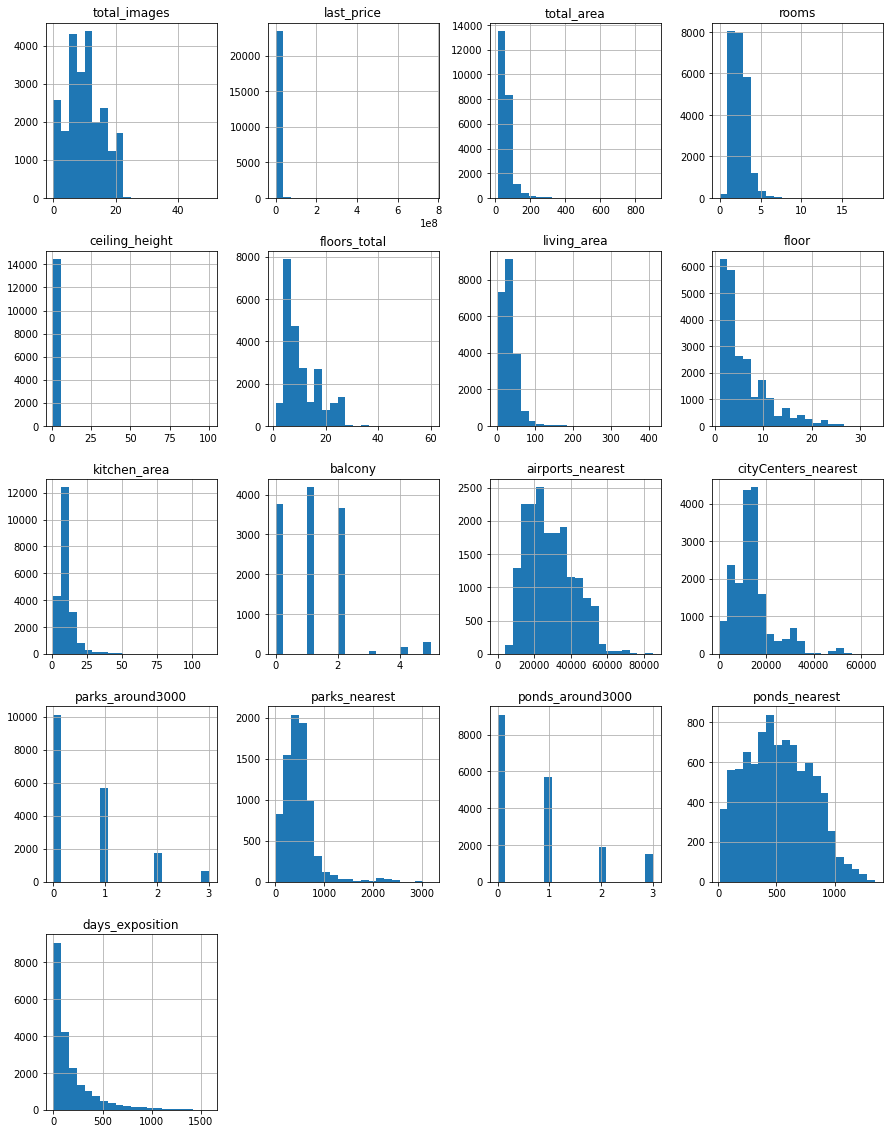

In [6]:
data.hist(figsize=(15, 20), bins=20) #построение гистограмм

In [7]:
shape=data.shape[0]
shape

23699

В датафрейме 23699 записей, на гистограммах видны аномальные значения, а благодаря методу describe() - видны минимумы и максимумы всех колонок, большинство из них требуют фильтрации аномальных значений. После их удаления и заполнения пропущенных значений, данные будут пригодны к объективному анализу. 

### Предобработка данных


#### Изменение типа данных, названия колонок, заполнение пропусков

In [8]:
data = data.rename(columns={'cityCenters_nearest': 'city_centers_nearest', 
                            'parks_around3000': 'parks_around_3000', 
                            'ponds_around3000': 'ponds_around_3000'}) #переименовываем в правильный snake_case

Применили правильные названия столбцов, далее заполнение пропусков

**Пропущенные значения наблюдаются в столбцах:**

In [9]:
data.isna().sum() #считаем пропуски. Во многих столбцах нельзя заменить пропущенные данные, так как это может исказить настоящую информацию о квартире

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
city_centers_nearest     5519
parks_around_3000        5518
parks_nearest           15620
ponds_around_3000        5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

*Пропуски данных в этих столбцах возникают, в большинстве, из-за человеческого фактора. Не все продавцы заполняют полную информацию, когда создают объявление. Но так же не стоит упускать возможность появления пропусков из-за багов, технических неполадок, отсутствия необходимой информации.*

Из всех пропусков мы можем заменить только пропуски в колонках is_apartment и balcony на False и 0 соответственно. Потому что владельцы жилых помещений просто не указывают информацию об апартаментах, а количество балокнов не указывают из-за их отсутствия 

In [10]:
data['is_apartment'].fillna(False, inplace=True)
data['balcony'].fillna(0, inplace=True)

In [11]:
data[['is_apartment', 'balcony']].isna().sum() #проверка замены

is_apartment    0
balcony         0
dtype: int64

Столбцы - first_day_exposition - замена в формат datetime из object
<br>Остальные замены в тип данных int64 нужны для того, чтобы заменить float64, в переменных, где встречаются только целые числа
<br>*В некоторых столбцах, например, floors_total из-за отсутствия данных невозможно сменить тип на int64*


In [12]:
data['first_day_exposition'] = pd.to_datetime(
    data['first_day_exposition'],format='%Y-%m-%dT%H:%M:%S')
data['last_price'] = data['last_price'].astype('int')
data['balcony'] = data['balcony'].astype('int')

In [13]:
data[['first_day_exposition', 'last_price', 'balcony']].dtypes #проверка

first_day_exposition    datetime64[ns]
last_price                       int64
balcony                          int64
dtype: object

#### Поиск и обработка дубликатов

In [14]:
data.duplicated().sum() #явные дубликаты

0

Явных дубликатов нет, значит придется искать дубликаты через уникальные значения. Искать их будем в столбце locality_name

In [15]:
data['locality_name'].sort_values().unique()

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Янино-1',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Павлово', 'городской посёлок Рощино',
       'городской посёлок Свирьстрой', 'городской посёлок Совет

Из уникальных значений видно:
<br>Нужно заменить строки содержащие Ё, есть такие же названия, но с буквой Е

In [16]:
data['locality_name'] = data['locality_name'].str.replace('ё', 'е')
data['locality_name'].sort_values().unique()

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалево',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Будогощь',
       'городской поселок Виллози', 'городской поселок Лесогорский',
       'городской поселок Мга', 'городской поселок Назия',
       'городской поселок Новоселье', 'городской поселок Павлово',
       'городской поселок Рощино', 'городской поселок Свирьстрой',
       'городской поселок Советский', 'городской поселок Фед

Далее, я заметил, что встречаются городской поселок Мга и поселок городского типа Мга, поселок при железнодорожной станции Вещево и поселок станции Вещево и т.п. Нужно привести данные к одному виду

In [17]:
data['locality_name'] = data['locality_name'].str.replace('городской поселок', 'поселок городского типа')
data['locality_name'] = data['locality_name'].str.replace('поселок станции', 'поселок при железнодорожной станции')
data['locality_name'] = data['locality_name'].str.replace('коттеджный поселок', 'поселок')
data['locality_name'].sort_values().unique()

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалево',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'деревня Агалатово', 'деревня Аро', 'деревня Батово',
       'деревня Бегуницы', 'деревня Белогорка', 'деревня Большая Вруда',
       'деревня Большая Пустомержа', 'деревня Большие Колпаны',
       'деревня Большое Рейзино', 'деревня Большой Сабск', 'деревня Бор',
       'деревня Борисова Грива', 'деревня Ваганово', 'деревня Вартемяги',
       'деревня Вахнова Кара', 'деревня Выскатка

Повторяются некоторые названия населенных пунктов

In [18]:
data = data.replace({'locality_name':{'деревня Кудрово':'Кудрово', 'поселок Любань':'Любань', 'поселок Мурино':'Мурино', 'Никольское':'село Никольское', 'деревня Гарболово':'поселок Гарболово', 'деревня Зимитицы':'поселок Зимитицы', 'деревня Калитино':'поселок Калитино', 'деревня Рабитицы':'поселок Рабитицы', 'деревня Фёдоровское':'поселок городского типа Фёдоровское', 'деревня Щеглово':'поселок Щеглово', 'поселок Громово': 'поселок при железнодорожной станции Громово', 'поселок Рябово':'поселок городского типа Рябово', 'село Павлово':'поселок городского типа Павлово', 'садовое товарищество Приладожский':'поселок городского типа Приладожский', 'садовое товарищество Рахья':'поселок городского типа Рахья',}})
data['locality_name'].sort_values().unique()

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Новая Ладога',
       'Отрадное', 'Павловск', 'Петергоф', 'Пикалево', 'Подпорожье',
       'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург', 'Светогорск',
       'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор', 'Сясьстрой',
       'Тихвин', 'Тосно', 'Шлиссельбург', 'деревня Агалатово',
       'деревня Аро', 'деревня Батово', 'деревня Бегуницы',
       'деревня Белогорка', 'деревня Большая Вруда',
       'деревня Большая Пустомержа', 'деревня Большие Колпаны',
       'деревня Большое Рейзино', 'деревня Большой Сабск', 'деревня Бор',
       'деревня Борисова Грива', 'деревня Ваганово', 'деревня Вартемяги',
       'деревня Вахнова Кара', 'деревня Выскатка', 'деревня Гл

Все неявные дубликаты были обработанны, теперь можно удалить строки, в которых нет названия населенного пункта, так как их невозможно будет исследовать

In [19]:
data = data[data['locality_name'].isna() != True]
data['locality_name'].isna().sum()

0

**Удалил неявные дубликаты в названиях населенных пунктов, переименовал столбцы, привел их к правильному формату, заменил форматы столбцов на правильные, чтобы анализ был более объективным и можно было работать с датой и временем**

### Добавление в таблицу новых столбцов

In [20]:
data['metr_price'] = data['last_price'] / data['total_area'] #цена одного квадратного метра 
data['metr_price'] = data['metr_price'].round(2) #округление

In [21]:
data['day'] = data['first_day_exposition'].dt.weekday #день недели, месяц и год
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year

In [22]:
def floor_type_def(row): #создание фнукции определения этажа
    floor=row['floor']
    floors_total=row['floors_total'] #столбцы из датафрейма
    if floor == 1: 
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    else:
        return 'другой'

In [23]:
data['floor_type'] = data.apply(floor_type_def, axis=1) #применение функции

In [24]:
data['center_km'] = data['city_centers_nearest'] / 1000 #превод в километры
data['center_km'] = data['center_km'].round() #округление

In [25]:
data.head() #проверка столбцов

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,metr_price,day,month,year,floor_type,center_km
0,20,13000000,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,...,482.0,2.0,755.0,NaN,120370.37,3,3,2019,другой,16.0
1,7,3350000,40.4,2018-12-04,1,NaN,11.0,18.6,1,False,...,NaN,0.0,NaN,81.0,82920.79,1,12,2018,первый,19.0
2,10,5196000,56.0,2015-08-20,2,NaN,5.0,34.3,4,False,...,90.0,2.0,574.0,558.0,92785.71,3,8,2015,другой,14.0
3,0,64900000,159.0,2015-07-24,3,NaN,14.0,NaN,9,False,...,84.0,3.0,234.0,424.0,408176.10,4,7,2015,другой,7.0
4,2,10000000,100.0,2018-06-19,2,3.03,14.0,32.0,13,False,...,112.0,1.0,48.0,121.0,100000.00,1,6,2018,другой,8.0


**Для определения типа этажа была создана функция, были добавлены столбцы с днем недели, месяцем и годом публикации объявления, а так же - столбцы с расстоянием до центра и ценой за квадратный метр. После добавления новых столбцов, которые пригодятся для дальнейшего анализа, можно переходить непосредственно к анализу данных датафрейма**

### Исследовательский анализ данных

In [26]:
shape_after_filtr = data.shape[0]
display(shape_after_filtr)
display(shape)

23650

23699

После фильтрации дубликатов и заполнения пропусков, количество строк сократилось на 49. Можно проводить актуальный анализ данных, так как более 90% данных сохранено

#### Общая площадь

In [27]:
data['total_area'].describe()

count    23650.000000
mean        60.329069
std         35.661808
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64

После применения describe(), видно, что первый квартиль = 40, третий квартиль = 69. IQR приблизительно равен 35.6.

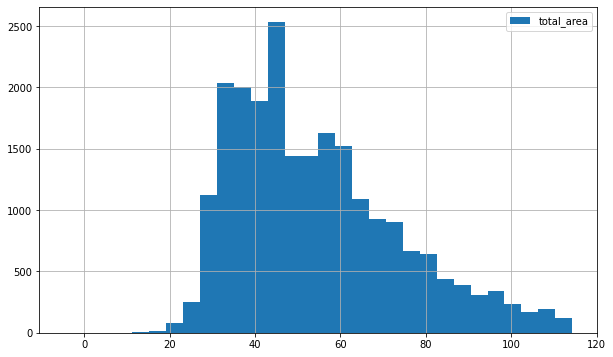

In [28]:
q1 = data['total_area'].quantile(.25) 
q3 = data['total_area'].quantile(.75)
iqr = q3 - q1 #межквартильный размах
data['total_area'].hist(range=(q1-1.5*iqr, q3+1.5*iqr), bins=30, legend=True, grid=True, figsize=(10, 6)) #составление гистограммы без выбросов
plt.show()

Изучив данные о полной площади квартир (не беря в счет выдающиеся значения), можно сделать вывод, что площадь большинства квартир равна 45 метрам. Основную часть от всех составляют квартиры площадью 26-65 квадратных метров. После 60 квадратных метров количество квартир на продаже сокращается пропорционально повышению площади квартиры.

#### Жилая площадь

In [29]:
data['living_area'].describe()

count    21752.000000
mean        34.448356
std         22.037664
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

В этом случае шаги те же, что и в исследовании общей площади. Q1 = 18, Q3 = 42.

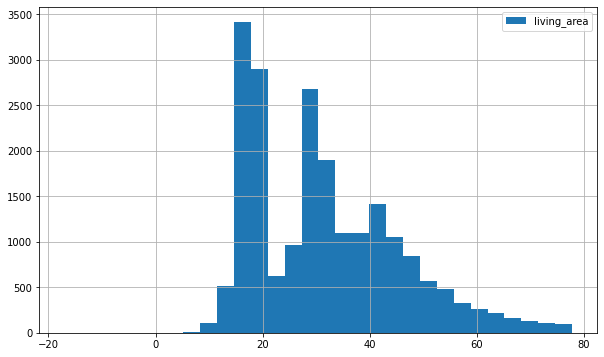

In [30]:
q1 = data['living_area'].quantile(.25)
q3 = data['living_area'].quantile(.75)
iqr = q3 - q1
data['living_area'].hist(range=(q1-1.5*iqr, q3+1.5*iqr), bins=30, legend=True, grid=True, figsize=(10, 6)) #составление гистограммы без выбросов
plt.show()

Исходя из данных гистограммы, можно сделать вывод, что у большинства продаваемых квартир жилая площадь примерно 16-18 кв.м., также есть пик в районе 28-30кв.м.
<br>Итого, часто встречаются квартиры с жилой площадью 16-30кв.м., но есть провал в районе 22-26кв.м.. Квартир с жилой площадью больше 45 и меньше 15 мало. 

#### Площадь кухни

In [31]:
data['kitchen_area'].describe()

count    21381.000000
mean        10.566403
std          5.901753
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

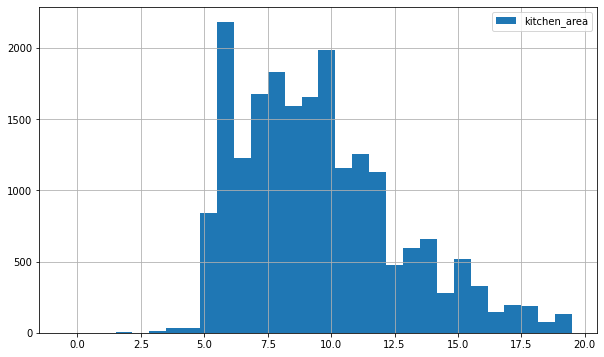

In [32]:
q1 = data['kitchen_area'].quantile(.25) #первый квартиль
q3 = data['kitchen_area'].quantile(.75) #третий квартиль
iqr = q3 - q1 #межквартильный размах
data['kitchen_area'].hist(range=(q1-1.5*iqr, q3+1.5*iqr), bins=30, legend=True, grid=True, figsize=(10, 6)) #составление гистограммы без выбросов
plt.show()

Изучив гистограмму площади кухни в продаваемых квартирах, я пришел к выводу, что у большинства квартир площадь кухни находится в пределах 5,5-12 квадратных метров. Самая распространенная площадь - около 5,5-6 метров. Кухни большей площади встречаются чаще, чем кухни меньшей площади.

#### Цена объекта

In [33]:
data['last_price'].describe()#описание столбца: квартили, медиана, среднее, максимум и минимум

count    2.365000e+04
mean     6.541127e+06
std      1.089640e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.799000e+06
max      7.630000e+08
Name: last_price, dtype: float64

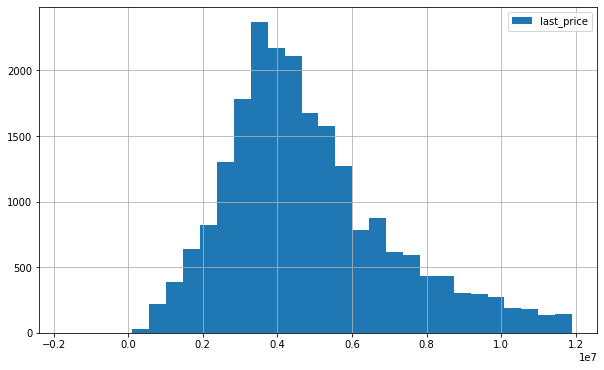

In [34]:
q1 = data['last_price'].quantile(.25) #первый квартиль
q3 = data['last_price'].quantile(.75) #третий квартиль
iqr = q3 - q1 #межквартильный размах
data['last_price'].hist(range=(q1-1.5*iqr, q3+1.5*iqr), bins=30, legend=True, grid=True, figsize=(10, 6)) #составление гистограммы без выбросов
plt.show() 
#ось Х умножаем на 10 миллионов рублей

Отбросив выбросы, и построив гистограмму на промежутке цены 0,5 млн - 12 млн, можно утверждать, что самая частая цена продажи квартир - от 3 до 5 миллионов рублей. Предложения, начиная с 5,5 млн плавно убавляются по мере возрастания цены. Среднее значение почти на 2 миллиона выше медианы из-за редких выдающихся значений.

#### Количество комнат

In [35]:
data['rooms'].describe()

count    23650.000000
mean         2.070106
std          1.078620
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

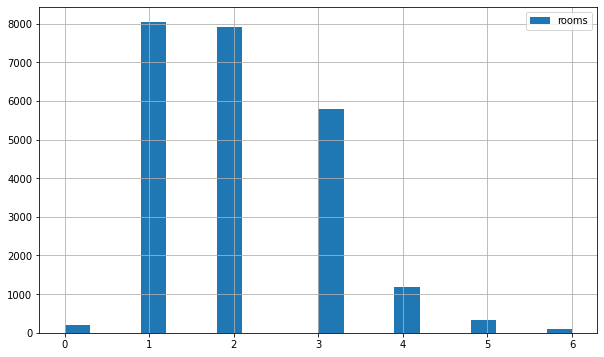

In [36]:
q1 = data['rooms'].quantile(.25) #первый квартиль
q3 = data['rooms'].quantile(.75) #третий квартиль
iqr = q3 - q1 #межквартильный размах
data['rooms'].hist(range=(0, q3+1.5*iqr), bins=20, legend=True, grid=True, figsize=(10, 6)) #составление гистограммы без выбросов
plt.show() 

Исходя из гистограммы, можно сделать вывод, что большинство квартир - однушки и двушки. Среднее и медиана совпадают (2 комнаты), что говорит о том, что выдающихся значений мало и они не сильно влияют на исследование. 3-х комнатных квартир чуть меньше, чем 1 и 2 комнатных, но тоже достаточно много, а вот квартир с 4, 5 и 6 комнатами - достаточно мало. Квартиры с 0 комнат тоже мало, скорее всего - это квартиры-студии

#### Высота потолков

In [37]:
data['ceiling_height'].describe()

count    14490.000000
mean         2.771287
std          1.261593
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

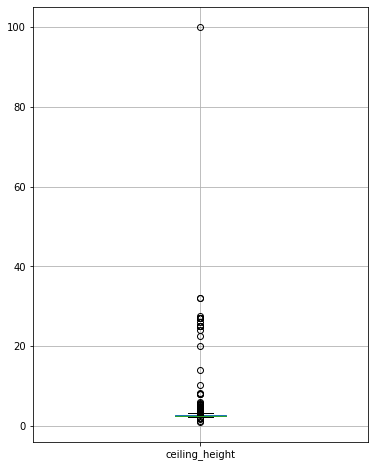

In [38]:
data.boxplot('ceiling_height', figsize=(6, 8))
plt.show()

В столбце с данными о высоте потолков много аномалий, перед исследованием нужно их обработать

In [39]:
data.loc[data['ceiling_height'] >= 20, 'ceiling_height'] = data['ceiling_height'] / 2 
#есть значения в районе 25-30 метров, что может быть опечаткой, их поделим на 2

In [40]:
data['ceiling_height'].describe() 

count    14490.000000
mean         2.747992
std          0.645839
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max         50.000000
Name: ceiling_height, dtype: float64

Среднее немного стало меньше, при округлении - 2.7 метра, а медиана не изменилась - 2,65 метра

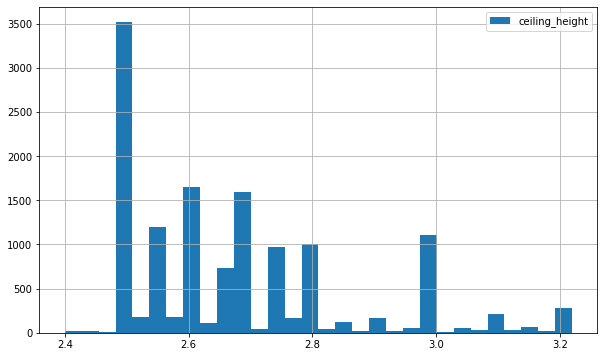

In [41]:
q1 = data['ceiling_height'].quantile(.25) #первый квартиль
q3 = data['ceiling_height'].quantile(.75) #третий квартиль
iqr = q3 - q1 #межквартильный размах
data['ceiling_height'].hist(range=(2.4, q3+1.5*iqr), bins=30, legend=True, grid=True, figsize=(10, 6)) #составление гистограммы без выбросов
plt.show() 

В данных о высоте потолков отсутствует часть данных, но убрав аномалии и проанализировав оставшиеся, можно придти к выводу, что большинство квартир на продаже имеет высоту потолков 2,5 метра. Также распространенной высотой являются 2,6 метра, 2,7 метра

#### Тип этажа и общее количество этажей в доме

In [42]:
data['floor_type'].value_counts()

другой       17408
последний     3330
первый        2912
Name: floor_type, dtype: int64

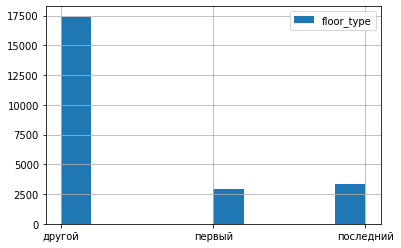

In [43]:
data['floor_type'].hist(figsize=(6, 4), grid=True, legend=True)
plt.show()

На этой гистограмме можно увидеть, что подавляющее большинство квартир в продаже расположенны ни на первом, ни на последнем этаже. Доля квартир на первом и на последнем приблизительно равна
<br>Далее - изучим какие этажи более популярные

In [44]:
data['floor'].describe()

count    23650.000000
mean         5.893277
std          4.883317
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

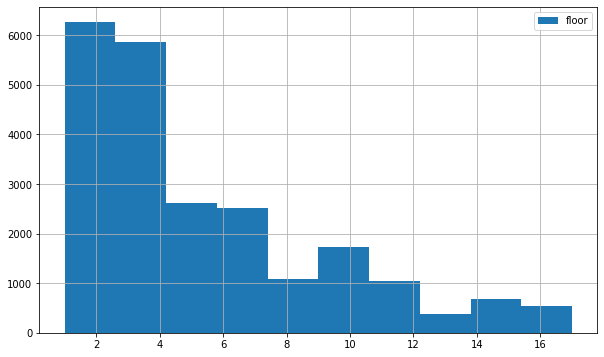

In [45]:
q1 = data['floor'].quantile(.25) #первый квартиль
q3 = data['floor'].quantile(.75) #третий квартиль
iqr = q3 - q1 #межквартильный размах
data['floor'].hist(range=(1, q3+1.5*iqr), bins=10, legend=True, grid=True, figsize=(10, 6)) #составление гистограммы без выбросов
plt.show() 

Теперь видно, что чем выше этаж - тем меньше объявлений о продаже квартир на этом этаже. Самые распространенные - первые 5 этажей, а первые два - в лидерах. Медиана близка к популярным этажам на графике (4 этаж)

#### Общее количество этажей в доме

In [46]:
data['floors_total'].describe()

count    23565.000000
mean        10.675875
std          6.594823
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

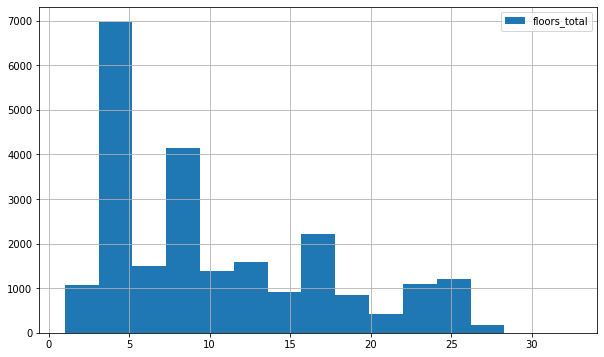

In [47]:
q1 = data['floors_total'].quantile(.25) #первый квартиль
q3 = data['floors_total'].quantile(.75) #третий квартиль
iqr = q3 - q1 #межквартильный размах
data['floors_total'].hist(range=(1, q3+1.5*iqr), bins=15, legend=True, grid=True, figsize=(10, 6)) #составление гистограммы без выбросов
plt.show() 

Исходя из гистограммы по данным об общем количестве этажей в доме - очевидно, лидерами оказываются дома 5-и этажные и 9-и этажные. В след за ними идут 16-и этажные высотки. Домов с другой этажностью примерно одинаковое количество

#### Расстояние до центра города в метрах и расстояние до ближайшего парка

In [48]:
data['parks_nearest'].describe()

count    8064.000000
mean      490.830729
std       342.554386
min         1.000000
25%       288.000000
50%       454.500000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

In [49]:
data['city_centers_nearest'].describe()

count    18139.000000
mean     14197.860742
std       8606.830295
min        181.000000
25%       9241.000000
50%      13105.000000
75%      16293.000000
max      65968.000000
Name: city_centers_nearest, dtype: float64

Данных с количеством парков меньше, чем данных о расстоянии до центра. Максимальное расстояние до ближайшего парка - 3,2 километра, а максимум расстояния до центра - 66 километров

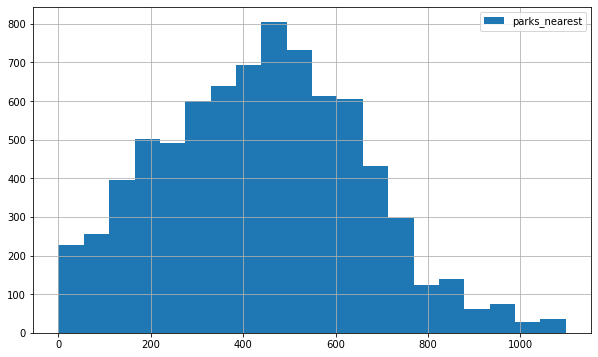

In [50]:
q1 = data['parks_nearest'].quantile(.25) #первый квартиль
q3 = data['parks_nearest'].quantile(.75) #третий квартиль
iqr = q3 - q1 #межквартильный размах
data['parks_nearest'].hist(range=(0, q3+1.5*iqr), bins=20, legend=True, grid=True, figsize=(10, 6)) #составление гистограммы без выбросов
plt.show() 

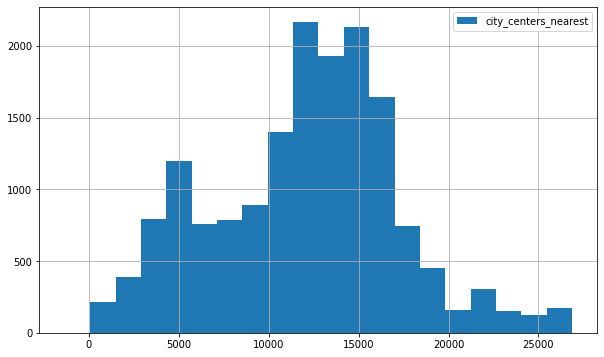

In [51]:
q1 = data['city_centers_nearest'].quantile(.25) #первый квартиль
q3 = data['city_centers_nearest'].quantile(.75) #третий квартиль
iqr = q3 - q1 #межквартильный размах
data['city_centers_nearest'].hist(range=(q1-1.5*iqr, q3+1.5*iqr), bins=20, legend=True, grid=True, figsize=(10, 6)) #составление гистограммы без выбросов
plt.show() 

Изучив две гистограммы, можно сделать вывод, что в большинстве случаев, ближайший парк находится в 300-700 метрах от дома, где продается квартира, значений меньше 300м больше, чем значений больше 700м, это говорит о том, что у большинства квартир, по которым есть данные, рядом есть парк. Расстояние до центра - 12-17км самое популярное. Квартир удаленных от центра, больше чем на 18км, намного меньше, чем квартир ближе к центру (до 10 километров)

**Изучив гистограммы, я пришел к выводу, что типичный объект недвижимости - это 1-3х комнатная квартира площадью приблизительно 30-45кв.м., с жилой площадью 16-30кв.м., кухней 5,5-12кв.м., потолками 2,5-2,7м в высоту, стоимостью от 3 до 5 миллионов рублей. Такая квартира может находиться на 1-5 этаже, рядом с домом есть парк, а расстояние до центра - 10-17км.**

#### Как быстро продаются квартиры?

In [52]:
data['days_exposition'].describe()

count    20470.000000
mean       180.753200
std        219.777916
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

Медиана в 95 дней на продаже не совпадает со средним - 180 дней на продаже. Это может происходить из-за выдающихся значений и аномалий, таких как максимум - 1580 дней (более 4-х лет).

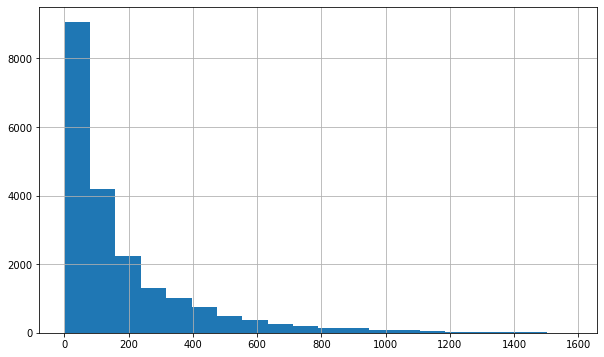

In [53]:
data['days_exposition'].hist(figsize=(10,6), bins=20)
plt.show()

Наблюдаем множество аномально больших значений, которые нужно отсекать

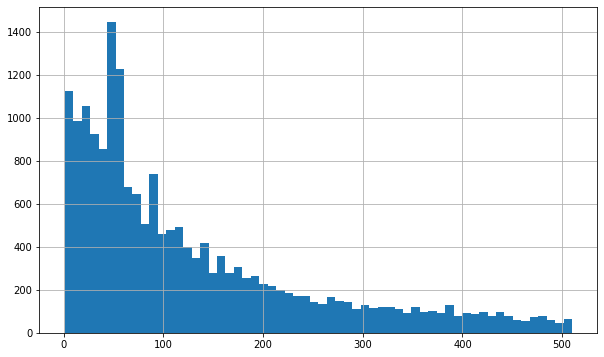

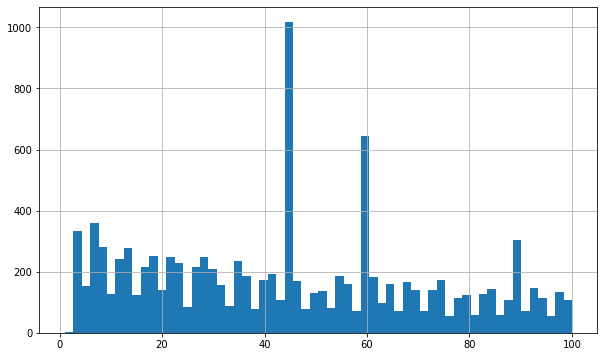

In [54]:
q1 = data['days_exposition'].quantile(.25) 
q3 = data['days_exposition'].quantile(.75) 
iqr = q3 - q1 #построим гистограмму без выбросов

data['days_exposition'].hist(range=(1, q3+1.5*iqr), bins=60, figsize=(10, 6))
plt.show()
data['days_exposition'].hist(range=(1, 100), bins=60, figsize=(10, 6)) #вторая гистограмма для более точного рассмотрения промежутка 0-100 дней
plt.show()

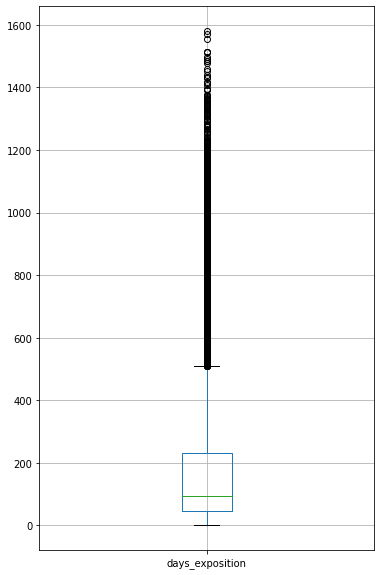

In [55]:
data.boxplot('days_exposition', figsize=(6, 10))
plt.show() #квартили на графике размаха - q1 = 45, q3 = 231

Глядя на гистограммы, можно сделать вывод, что пики продаж квартир расположены примерно на 45-м и 60-м и 90-м дне продажи (достаточно быстрые продажи). На этих днях на сайте объявления уходят в архив и их нужно публиковать заново. Аномально быстрые продаже расположены до 1-ой квартили q1 - продажи быстрее, чем за 45 дней. В большинстве, квартиры продаются за первые ~230 дней (3-я квартиль q3), дни далее уже можно назвать аномальными (еще могут быть различные факторы, завышенная цена, плохое местоположение, старый дом и т.п., поэтому объявления могут быть активными больше года)

#### Зависит ли цена от различных факторов

Зависит ли цена общей площади; жилой площади; площади кухни; количества комнат; этажа, на котором расположена квартира (первый, последний, другой); даты размещения (день недели, месяц, год)?

<function matplotlib.pyplot.show(close=None, block=None)>

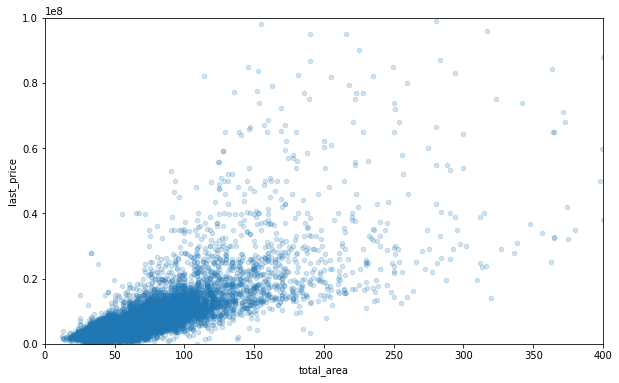

In [56]:
data.plot(x='total_area', y ='last_price', xlim=(0, 400), ylim=(0, 100000000), kind ='scatter', figsize=(10, 6), legend=True, alpha = 0.2)
plt.show

Из графика видно, что зависимость от общей площади есть: чем больше площадь, тем больше цена. Большинство значений в графике для квартир до 20 миллионов рублей

<function matplotlib.pyplot.show(close=None, block=None)>

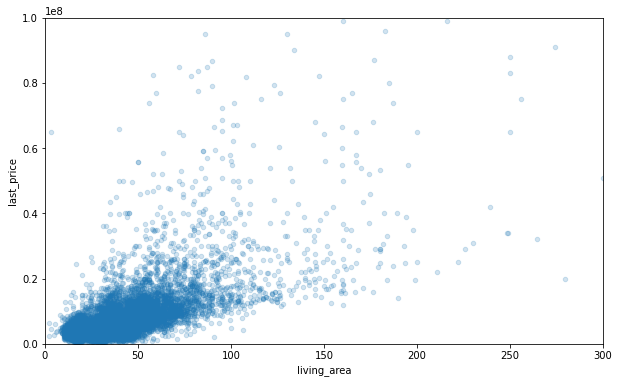

In [57]:
data.plot(x='living_area', y ='last_price', xlim=(0, 300), ylim=(0, 100000000), kind ='scatter', figsize=(10, 6), legend=True, alpha = 0.2)
plt.show

График зависимости жилой площади похож на график общей площади. Зависимость такая же - чем больше площадь, тем больше цена

<function matplotlib.pyplot.show(close=None, block=None)>

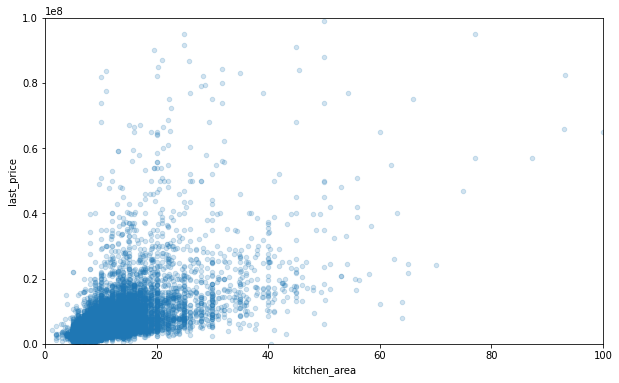

In [58]:
data.plot(x='kitchen_area', y ='last_price', xlim=(0, 100), ylim=(0, 100000000), kind ='scatter', figsize=(10, 6), legend=True, alpha = 0.2)
plt.show

Зависимость цены от площади кухни также прямо пропорциональная - больше площадь кухни - больше цена

<function matplotlib.pyplot.show(close=None, block=None)>

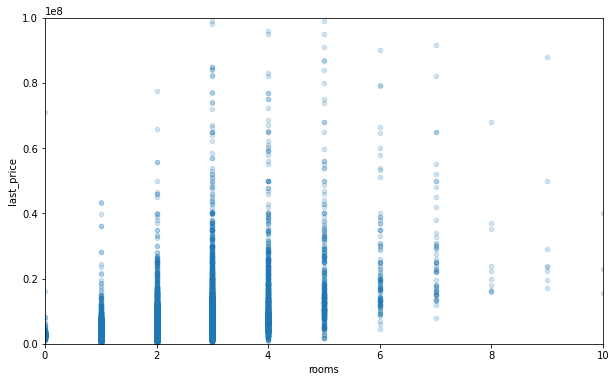

In [59]:
data.plot(x='rooms', y ='last_price', xlim=(0, 10), ylim=(0, 100000000), kind ='scatter', figsize=(10, 6), legend=True, alpha = 0.2)
plt.show

Зависимость наблюдается: больше всего данных для квартир с 1-4 комнатами, больше комнат - цена выше. Цены на 3 и 4 комнатные квартиры примерно одинаковые, на квартиры с 5-ю комнатами цена чуть меньше (обычно 5 комнат в старых домах с маленькой жилой площадью)

In [60]:
floor_category = data.pivot_table(index='floor_type', values='last_price', aggfunc=['mean', 'count', 'median'])
display(floor_category)

,mean,count,median
,last_price,last_price,last_price
floor_type,,,
другой,6.675825e+06,17408,4850000
первый,4.800465e+06,2912,3900000
последний,7.359138e+06,3330,4300000


<function matplotlib.pyplot.show(close=None, block=None)>

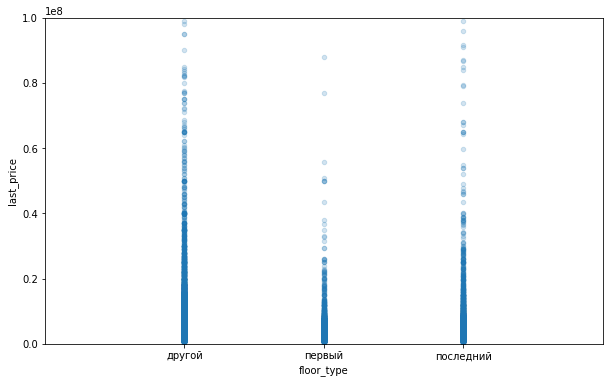

In [61]:
data.plot(x='floor_type', y ='last_price', xlim=(-1, 3), ylim=(0, 100000000), kind ='scatter', figsize=(10, 6), legend=True, alpha = 0.2)
plt.show

Из графика и сводной таблицы видно, что квартиры на первом этаже ценятся меньше, чем на последнем, у других этажей максимальный разбег цены, а медиана цен выше

<function matplotlib.pyplot.show(close=None, block=None)>

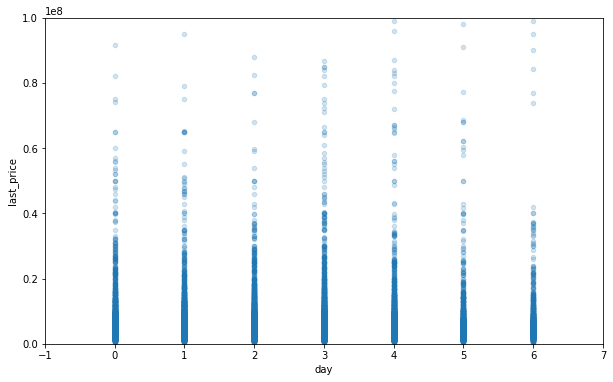

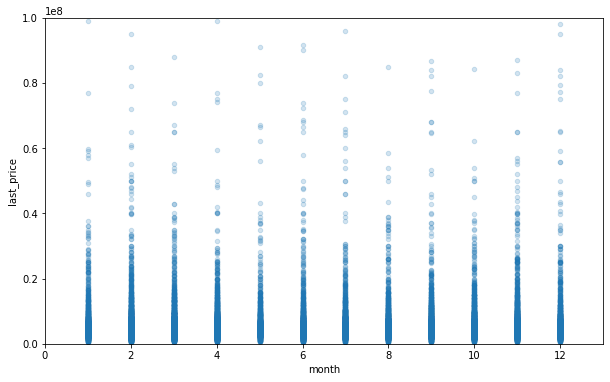

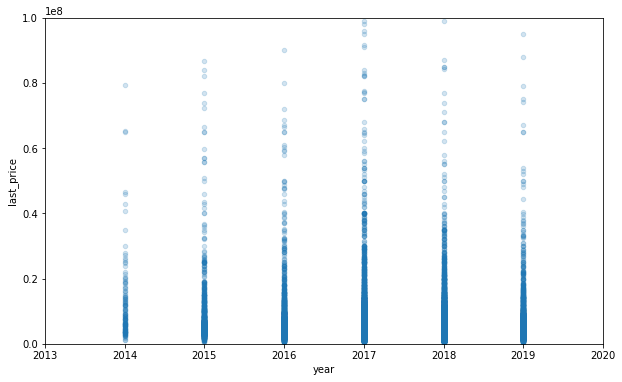

In [62]:
data.plot(x='day', y ='last_price', xlim=(-1, 7), ylim=(0, 100000000), kind='scatter', figsize=(10, 6), legend=True, alpha = 0.2)
plt.show
data.plot(x='month', y ='last_price', xlim=(0, 13), ylim=(0, 100000000), kind ='scatter', figsize=(10, 6), legend=True, alpha = 0.2)
plt.show
data.plot(x='year', y ='last_price', xlim=(2013, 2020), ylim=(0, 100000000), kind ='scatter', figsize=(10, 6), legend=True, alpha = 0.2)
plt.show

In [63]:
data.pivot_table(index='year', 
                 values='total_area').sort_values(by='total_area') #отслеживаем динамику метража квартир по годам

,total_area
year,
2018,57.666359
2019,59.467864
2017,60.746788
2016,62.143852
2015,71.569923
2014,86.225956


Из графиков зависимости цены от дня недели/месяца/года можно сделать вывод, что зависимости почти нет, значительной корреляции не видно. С 2014 года по 2017 цены росли стабильно, после 2017 последовал небольшой спад цен, что объясняется спадом среднего метража продаваемых квартир

**Изучив графики, я пришел к выводу, что цена зависит от общей площади, жилой площади, площади кухни, количества комнат - прямо пропорциаонально; от этажа, на котором расположена квартира - наблюдается зависимость, первый этаж ценится чуть меньше, чем последний; но особой зависимости от даты размещения (день недели, месяц, год) - не наблюдается, но, начиная с 2014 года средняя жилая площадь продаваемых квартир понижается**

#### Средняя цена одного квадратного метра в 10 населённых пунктах 

In [64]:
top10 = data['locality_name'].value_counts().head(10)
top10 #переменная для будущей таблицы, которая вклюает в себя топ 10 населенных пунктов по количеству объявлений

Санкт-Петербург      15721
Мурино                 590
Кудрово                472
поселок Шушары         440
Всеволожск             398
Пушкин                 369
Колпино                338
поселок Парголово      327
Гатчина                307
Выборг                 237
Name: locality_name, dtype: int64

In [65]:
top_10_tab = data.query('locality_name in @top10.index') #создание таблицы с данными только из населенных пунктов топ 10 по количеству объявлений
#обращение ко внешней переменной через @

In [66]:
top_10_pivot = top_10_tab.pivot_table(index='locality_name', values='metr_price', aggfunc=['mean', 'median']) #Создание сводной таблицы
top_10_pivot.columns = ['mean', 'median'] #переименовываем столбцы
top_10_pivot.sort_values(by='median', ascending=False) #сортировка получившихся значений по медиане

,mean,median
locality_name,,
Санкт-Петербург,114849.008793,104761.900
Пушкин,103125.819377,100000.000
Кудрово,95324.930508,95675.475
поселок Парголово,90175.913089,91642.860
Мурино,86087.512017,86175.640
поселок Шушары,78677.364318,76876.175
Колпино,75424.579112,74723.745
Гатчина,68746.146515,67796.610
Всеволожск,68654.473970,65789.470


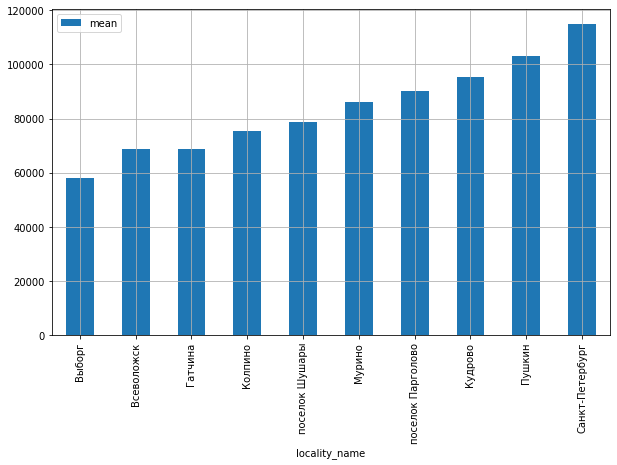

In [67]:
top_10_pivot.sort_values(by='mean').plot(y='mean', kind='bar', grid=True, figsize=(10, 6))
plt.show()

Из топ-10 населенных пунктов, самая дорогая средняя цена за квадратный метр, ожидаемо в Санкт-Петербурге (114тыс.р.). За ним следует Пушкин (103тыс.р.). Последним в списке средней цены за квадратный метр в топ-10 оказался Выборг с ценой 58тыс.р.

#### Цена в зависимости от расположения в СПБ

In [68]:
spb_tab = data.query('locality_name == "Санкт-Петербург"') #срез с названием населенного пункта Санкт-Петербург
display(spb_tab.head())

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,metr_price,day,month,year,floor_type,center_km
0,20,13000000,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,...,482.0,2.0,755.0,NaN,120370.37,3,3,2019,другой,16.0
2,10,5196000,56.0,2015-08-20,2,NaN,5.0,34.3,4,False,...,90.0,2.0,574.0,558.0,92785.71,3,8,2015,другой,14.0
3,0,64900000,159.0,2015-07-24,3,NaN,14.0,NaN,9,False,...,84.0,3.0,234.0,424.0,408176.10,4,7,2015,другой,7.0
4,2,10000000,100.0,2018-06-19,2,3.03,14.0,32.0,13,False,...,112.0,1.0,48.0,121.0,100000.00,1,6,2018,другой,8.0
7,5,7915000,71.6,2019-04-18,2,NaN,24.0,NaN,22,False,...,NaN,0.0,NaN,NaN,110544.69,3,4,2019,другой,12.0


In [69]:
spb_pivot = spb_tab.pivot_table(index='center_km', #сводная таблица
                               values='metr_price',
                               aggfunc=['mean', 'median'])
spb_pivot.columns=['mean', 'median']
spb_pivot.sort_values(by='mean', ascending=False)
display(spb_pivot)

,mean,median
center_km,,
0.0,245833.530370,172619.050
1.0,177005.407604,128485.110
2.0,157849.007290,123035.515
3.0,121387.453743,108469.115
4.0,133282.874738,117952.265
5.0,140509.789022,127093.280
6.0,151012.193673,131835.225
7.0,156176.879524,127017.080
8.0,125671.442864,122944.930


По сводной таблице сразу видно, что после сортировки значений средней стоимости по убыванию - самая высокая стоимость квадратного метра, ожидаемо, в самом центре. После 8-го километра от центра, сердняя цена начинает постепенно падать по мере удаления от центра.

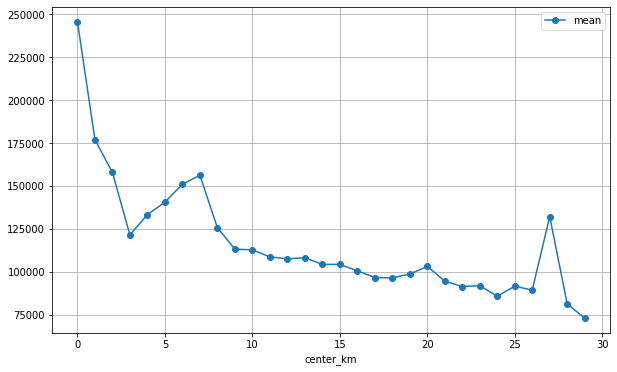

In [70]:
spb_pivot.plot(y='mean', grid=True, style='-o', figsize=(10, 6))
plt.show()

На графике отчетливо виден спад после 8-го километра, пик цены в самом центре, а так же пик цены в районе 27-го километра, что может говорить о нахождении там новостроек или элитного жилья.

### Напишите общий вывод

Была проделана работа с пропусками, изменен тип столбцов, изменены названия столбцов, проанализированны данные (без аномалий - при помощи квартили, межквартильного размаха).
<br>
<br>**Итог исследования: **
<br>- большее всего на цену квартиры **влияет ее общая и жилая площадь**, также влияет метраж кухни, количество комнат, расстояние до центра города (Санкт-Петербурга)
<br>- квартиры в **центре Санкт-Петербурга - самые дорогие по цене квадратного метра.** После удаления на 8 километров от центра - начинается спад цен на квадратный метр. В районе 27-го километра от СПБ находится элитная недвижимость
<br>- квартиры **в Выборге - последние по стоимости квадратного метра,** среди топ-10 населенных пунктов по количеству объявлений
<br>- **типичный объект недвижимости** - это 1-3х комнатная квартира площадью приблизительно 30-45кв.м., с жилой площадью 16-30кв.м., кухней 5,5-12кв.м., потолками 2,5-2,7м в высоту, стоимостью от 3 до 5 миллионов рублей. Такая квартира может находиться на 1-5 этаже, рядом с домом есть парк, а расстояние до центра - 10-17км
<br>- **время продажи квартиры обычно занимает до 200-240 дней,** пики наблюдаются на 45 и 60 днях. До 45 дней - быстрая продажа. Но есть и объявления, активные уже долгое время

**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Файл с данными открыт.
- [x]  Файл с данными изучен: выведены первые строки, использован метод `info()`, построены гистограммы.
- [x]  Найдены пропущенные значения.
- [x]  Пропущенные значения заполнены там, где это возможно.
- [x]  Объяснено, какие пропущенные значения обнаружены.
- [x]  В каждом столбце установлен корректный тип данных.
- [x]  Объяснено, в каких столбцах изменён тип данных и почему.
- [x]  Устранены неявные дубликаты в названиях населённых пунктов.
- [x]  Обработаны редкие и выбивающиеся значения (аномалии).
- [x]  В таблицу добавлены новые параметры:
       – цена одного квадратного метра;
       – день публикации объявления (0 - понедельник, 1 - вторник и т. д.);
       – месяц публикации объявления;
       – год публикации объявления;
       – тип этажа квартиры (значения — «первый», «последний», «другой»);
       – расстояние до центра города в километрах.
- [x]  Изучены и описаны параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего парка.
- [x]  Выполнено задание «Изучите, как быстро продавались квартиры (столбец `days_exposition`)»:
    - построена гистограмма;
    - рассчитаны среднее и медиана;
    - описано, сколько обычно занимает продажа и указано, какие продажи можно считать быстрыми, а какие — необычно долгими.
- [x]  Выполнено задание «Определите факторы, которые больше всего влияют на общую (полную) стоимость объекта». Построены графики, которые показывают зависимость цены от параметров:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - количество комнат;
        - тип этажа, на котором расположена квартира (первый, последний, другой);
        - дата размещения (день недели, месяц, год).
- [x]  Выполнено задание «Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений»:
    - выделены населённые пункты с самой высокой и низкой стоимостью квадратного метра.
- [x]  Выполнено задание «Выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите их среднюю стоимость на разном удалении от центра»:
    -  учтён каждый километр расстояния, известны средние цены квартир в одном километре от центра, в двух и так далее;
    -  описано, как стоимость объекта зависит от расстояния до центра города;
    -  построен график изменения средней цены для каждого километра от центра Петербурга.
- [x]  На каждом этапе сделаны промежуточные выводы.
- [x]  В конце проекта сделан общий вывод.